In [1]:
using HDF5
using JSON
using Plots, LinearAlgebra, Statistics, Random, StatsBase, Compat, Distributions

data = Dict()

filenames = ["mcmc_electron.hdf5"];


# d = Uniform(0, 35)
# data_samples = Array{Float64, 1}()
# counter = 0
# while counter < 10000
#     x = rand(d)
#     if abs(x) <= 30.5
#         counter += 1
#         push!(data_samples, convert(Int, round(x)))
#     end
# end
# u=unique(data_samples)
# thetas=Dict([(i,count(x->x==i,data_samples)) for i in u])

theta_distr = []

for filename in filenames
    println(filename)
    ligo = h5open(filename, "r")

    for elem in names(ligo)
        m = ligo[elem]
        j = JSON.parse(read(m)["meta"])
        data_array = [elem.data[1] for elem in read(m)["deposit"]]
        energy_value = j["values"]["macros"]["energy"]
        theta = j["values"]["macros"]["theta"]
        if theta == 0
            if !haskey(data, energy_value)
                data[energy_value] = []
            end
            append!(data[energy_value], data_array)
        end
    end

    close(ligo)
end

# for energy in keys(data)
#     Random.shuffle!(data[energy])
# end

mcmc_electron.hdf5


In [2]:
data_p = Dict()

filenames = ["mcmc_1_69.hdf5", "mcmc_70_99.hdf5", "mcmc_100_119.hdf5",
"mcmc_120_139.hdf5", "mcmc_140_150.hdf5"];

theta_distr = []

for filename in filenames
    println(filename)
    ligo = h5open(filename, "r")

    for elem in names(ligo)
        m = ligo[elem]
        j = JSON.parse(read(m)["meta"])
        data_array = [elem.data[1] for elem in read(m)["deposit"]]
        energy_value = j["values"]["macros"]["energy"]
        theta = j["values"]["macros"]["theta"]
        if theta == 0
            if !haskey(data_p, energy_value)
                data_p[energy_value] = []
            end
            append!(data_p[energy_value], data_array)
        end
    end

    close(ligo)
end


mcmc_1_69.hdf5
mcmc_70_99.hdf5
mcmc_100_119.hdf5
mcmc_120_139.hdf5
mcmc_140_150.hdf5


In [3]:
include("../../statreg_materials/StatReg.jl/src/StatReg.jl")
using .StatReg


plotly()
gr(size=(500,500), html_output_format=:png)

GLOBAL_RNG = 123
Random.seed!(123);

In [4]:
using Memoize
@memoize function K(E, y)
    return mean([elem[y] for elem in data[E]])
end
@memoize function K_p(E, y)
    return mean([elem[y] for elem in data_p[E]])
end

energy = sort(collect(keys(data)));
energy_p = sort(collect(keys(data_p)));
ln_energy = log.(energy);
ln_energy_p = log.(energy_p);

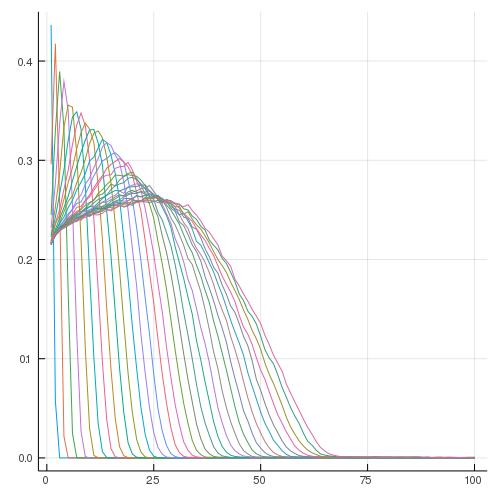

In [5]:
p = plot()
for e in energy
    p = plot!(collect(range(1, stop=100)), [K(e, y_) for y_ in collect(range(1, stop=100))], label="")
end
display(p)

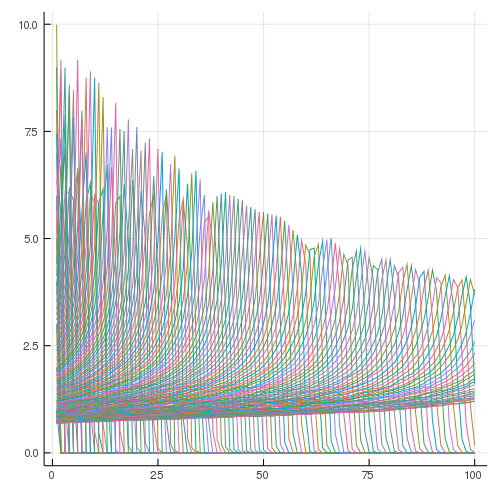

In [6]:
p = plot()
for e in energy_p
    p = plot!(collect(range(1, stop=100)), [K_p(e, y_) for y_ in collect(range(1, stop=100))], label="")
end
display(p)

In [7]:
function create_spectrum(n_energy, energy)
    arr = []
#     for (key, value) in data
#         n = n_energy[floor(Int, key*10)]
#         data_arr = sample(value, n)
#         append!(arr, data_arr)
#     end
    for (n, i) in zip(n_energy, energy)
        value = data[i]
        data_arr = sample(value, n)
        append!(arr, data_arr)
    end
    return sum(arr)
end

create_spectrum (generic function with 1 method)

In [8]:
function create_spectrum_p(n_energy, energy_p)
    arr = []
#     for (key, value) in data
#         n = n_energy[floor(Int, key*10)]
#         data_arr = sample(value, n)
#         append!(arr, data_arr)
#     end
    for (n, i) in zip(n_energy, energy_p)
        value = data_p[i]
        data_arr = sample(value, n)
        append!(arr, data_arr)
    end
    return sum(arr)
end

create_spectrum_p (generic function with 1 method)

In [9]:
function real_spectrum_p(E)
#     C = 3.26 * 10^7
#     ga = 0.87
#     gb = 4.68
#     E0 = 12.8
#     dt = 1.44 * 10^5
    C = 1.35 * 10^9
    ga = 1.04
    gb = 3.52
    E0 = 27.4
    dt = 1.19 * 10^5
    S = 10
    
    if E < (gb - ga) * E0
        return C * E^(-ga) * exp(- E / E0) / dt * S #* E
    else
        return C * E^(-gb) * ((gb-ga) * E0)^(gb-ga) * exp(ga-gb) / dt * S #* E
    end
end

function real_spectrum(E)
    Ca = 6.58 * 10^8 #* 10^3
    Cb = 1.46 * 10^8 #* 10^3
    ga = 1.90
    gb = 4.27
    dt = 1.19 * 10^5
    E0 = 0.5
    S = 10
#     Ca = 1.08 * 10^7
#     Cb = 1.67 * 10^7
#     ga = 1.50
#     gb = 3.98
#     dt = 2.27 * 10^5
#     E0 = 1.32
#     S = 10
    if E < E0
        return Ca * E^(-ga) / dt * S
    else
        return Cb * E^(-gb) / dt * S
    end
end


real_spectrum (generic function with 1 method)

In [10]:
arr_spectrum_real = [floor(Int, real_spectrum(x_)) for x_ in energy]
f_y = create_spectrum(arr_spectrum_real, energy);

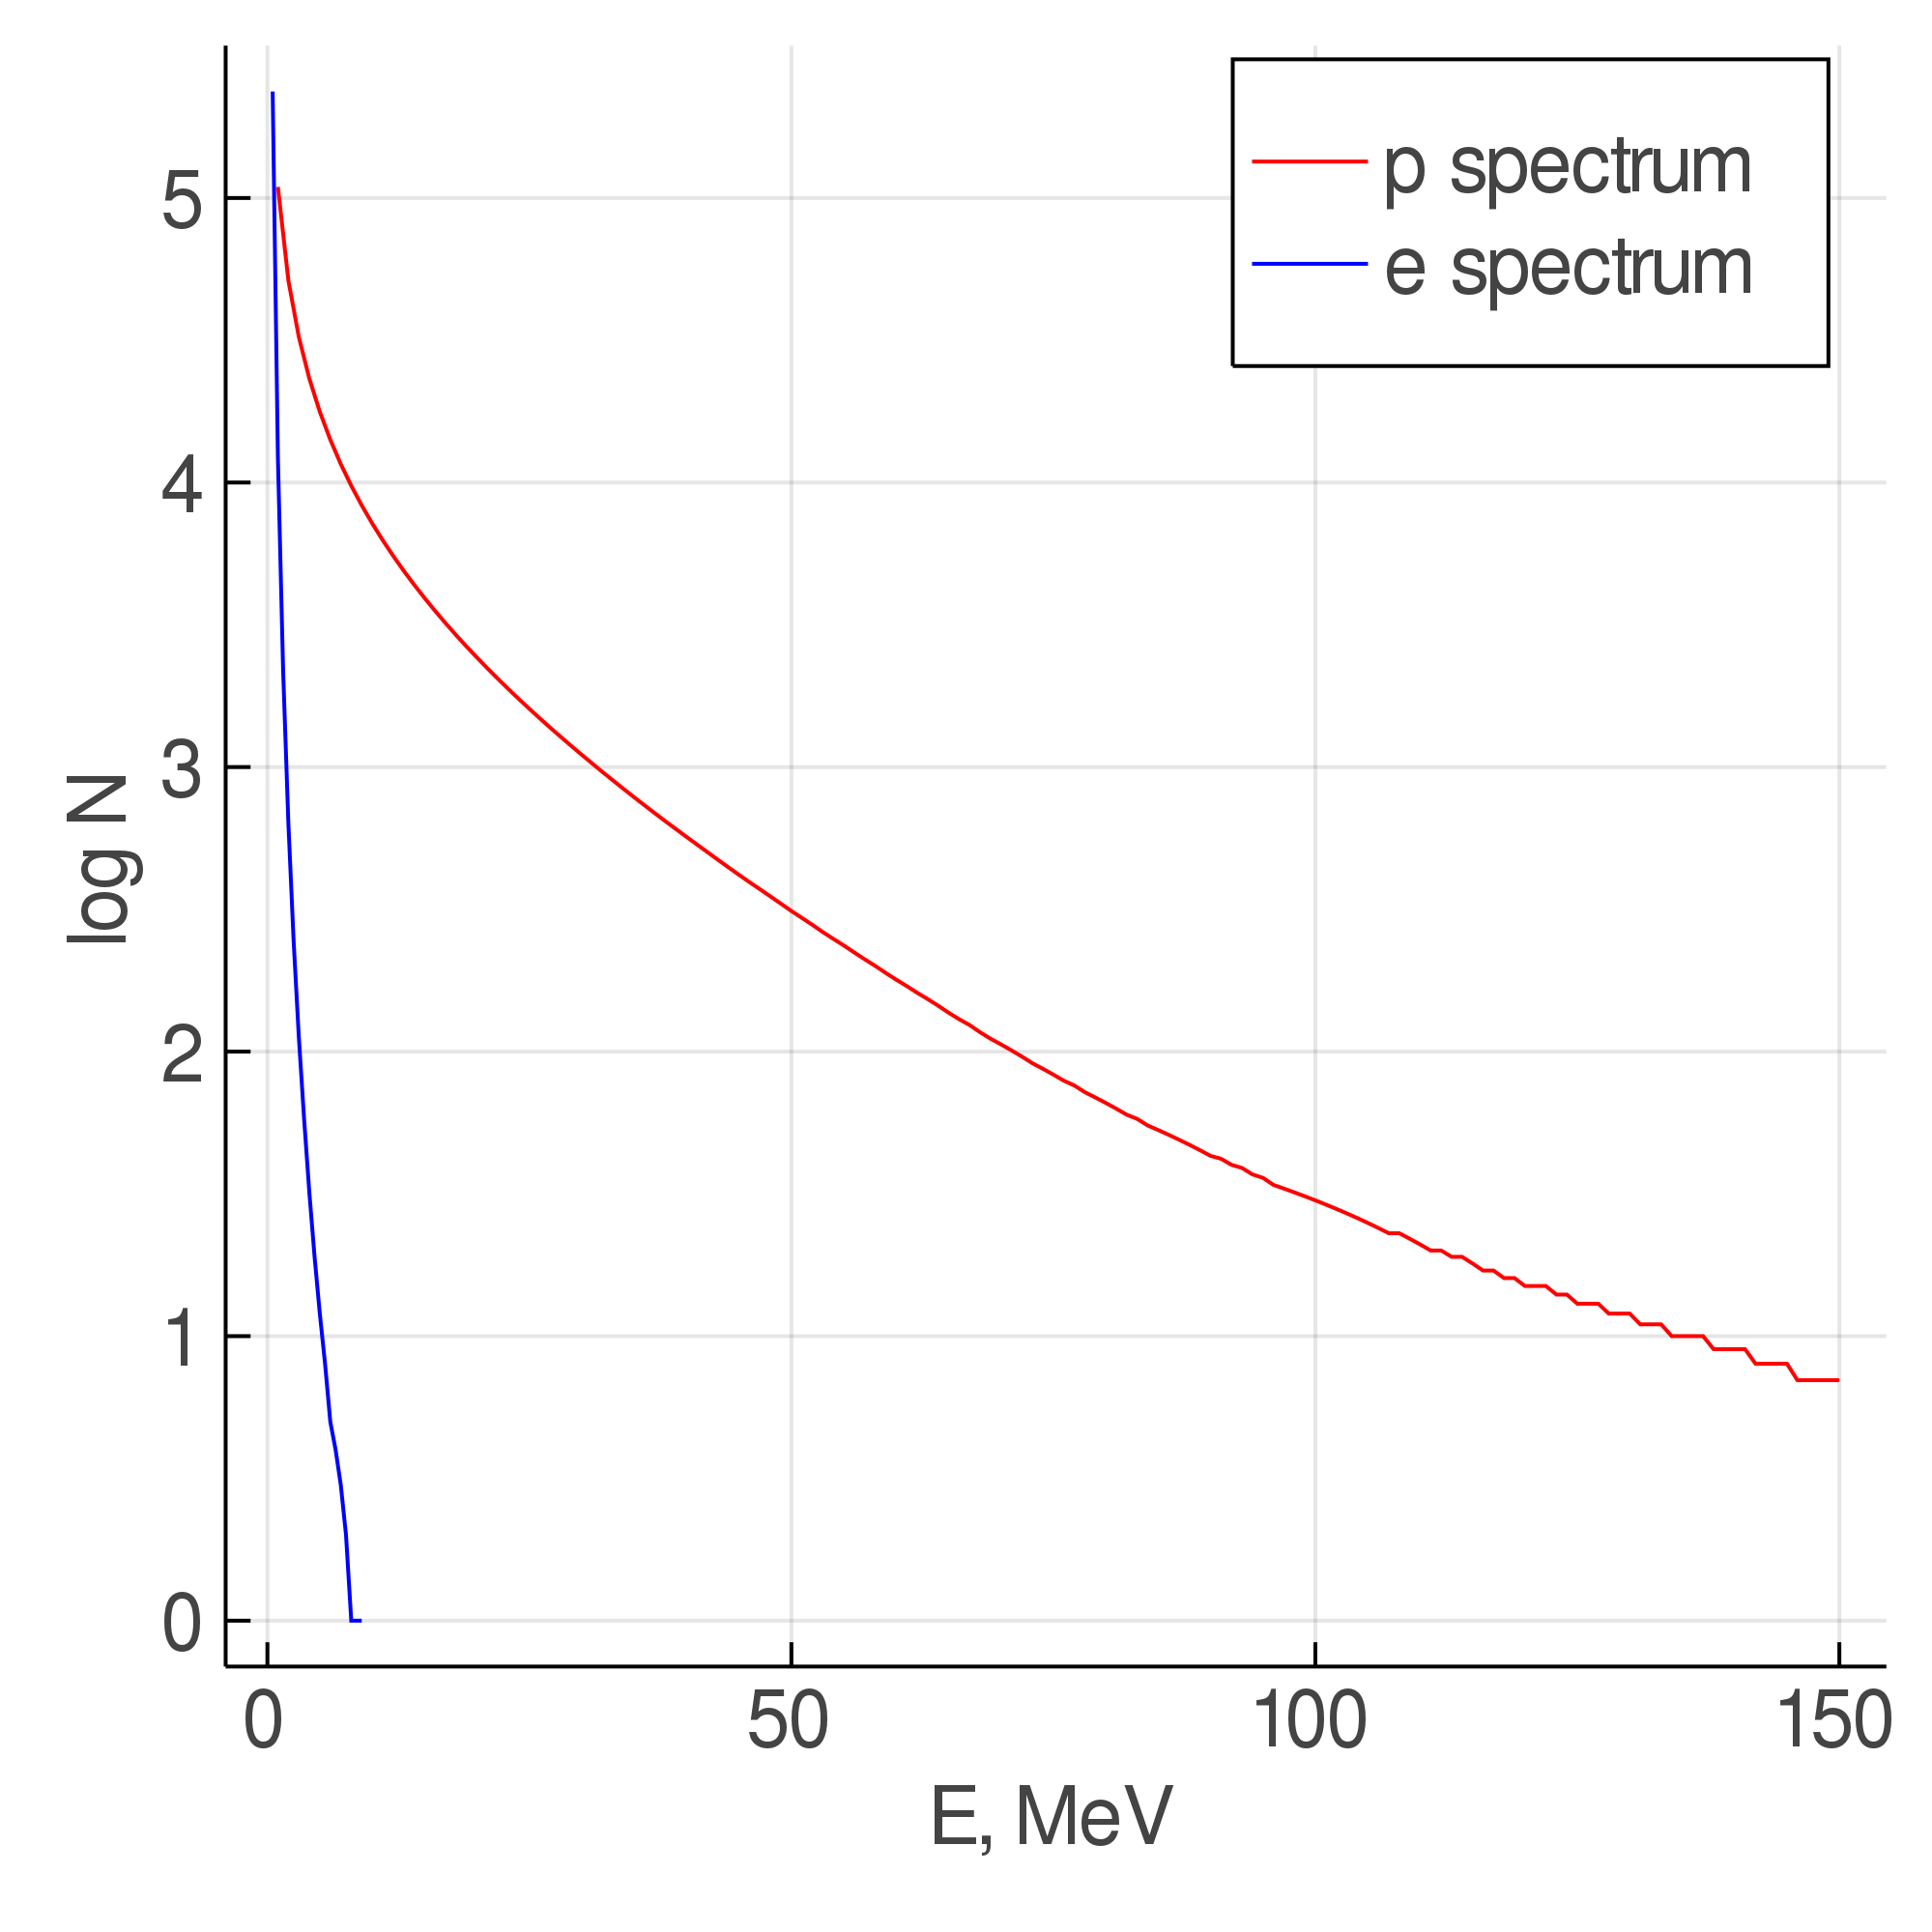

In [11]:
arr_spectrum_real_p = [floor(Int, real_spectrum_p(x_)) for x_ in energy_p]
f_y_p = create_spectrum_p(arr_spectrum_real_p, energy_p);

log_arr_spectrum_real_p = log.(10, arr_spectrum_real_p)
log_arr_spectrum_real = log.(10, arr_spectrum_real)

plot(energy_p, log_arr_spectrum_real_p, label="p spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :red)
plot!(energy, log_arr_spectrum_real, label="e spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
    xlabel="E, MeV", ylabel="log N")
# savefig("p_e_log_spectra.png")

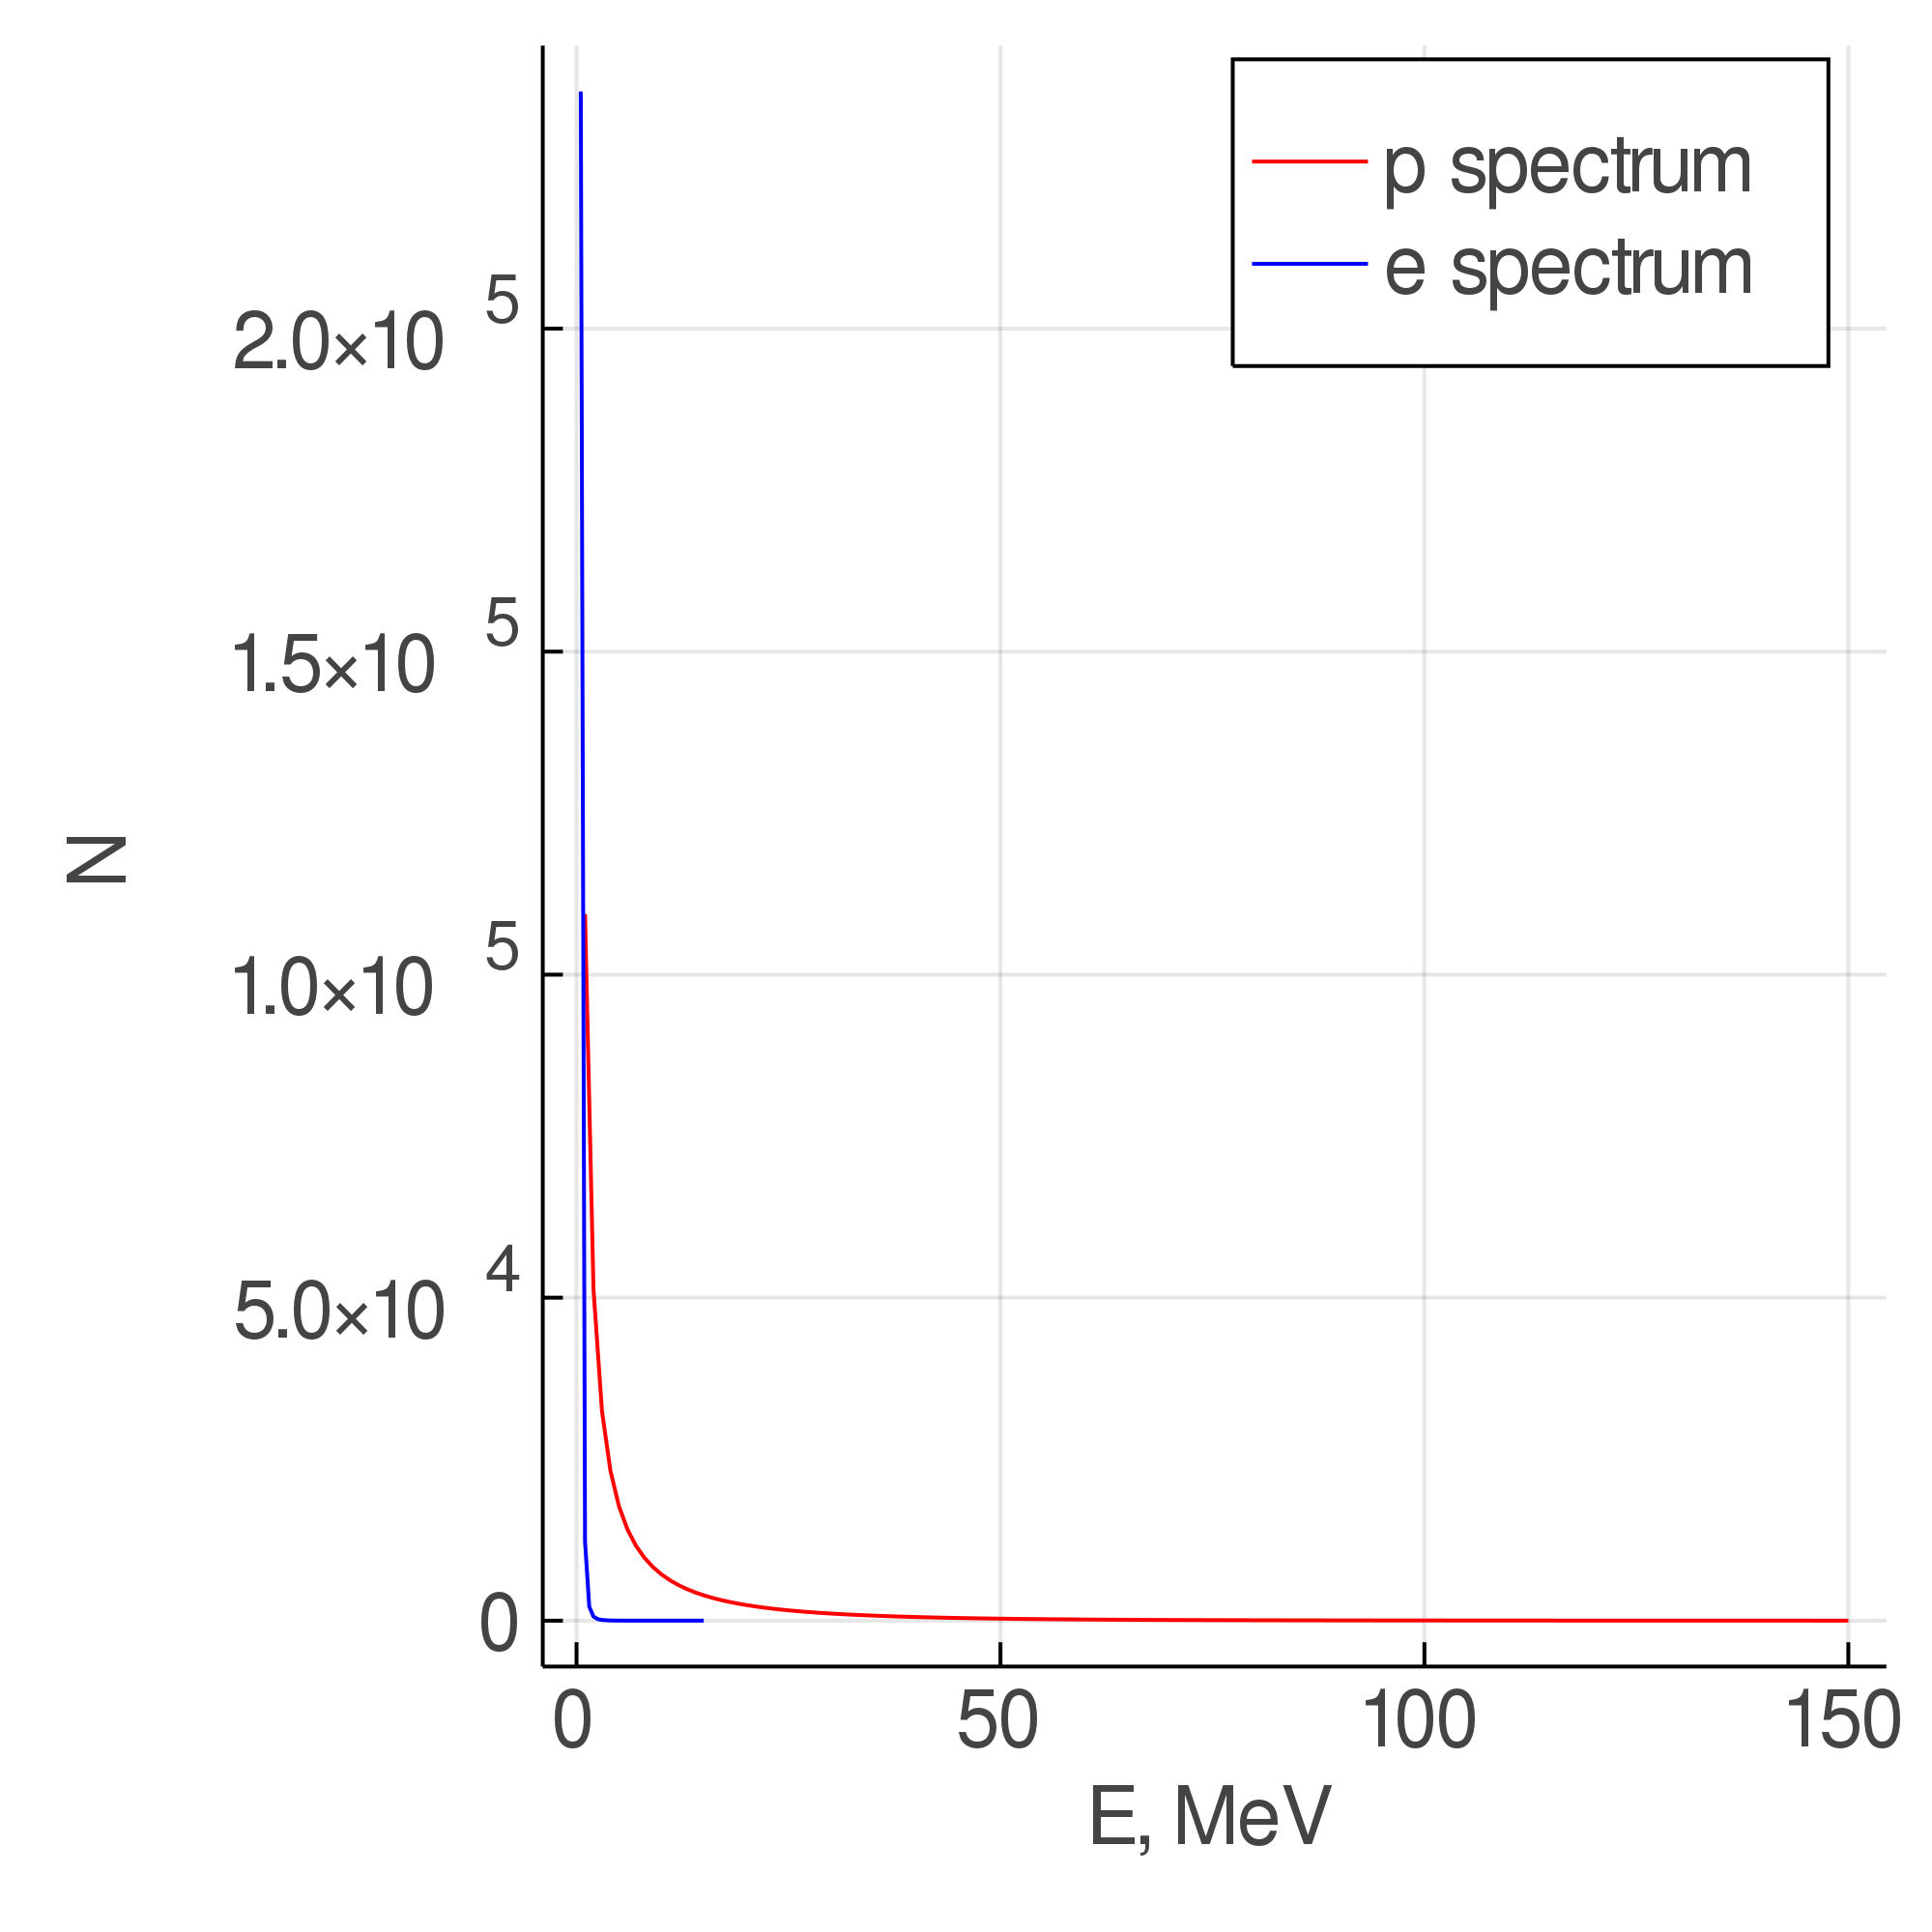

In [15]:
plot(energy_p, arr_spectrum_real_p, label="p spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :red)
plot!(energy, arr_spectrum_real, label="e spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
    xlabel="E, MeV", ylabel="N")
# savefig("p_e_spectra.png")

In [64]:
plot(energy_p[1:18], arr_spectrum_real_p[1:18], 
    label="p spectrum", dpi=400, xtickfontsize=14, ytickfontsize=14,
    legendfontsize=14, guidefont=font(14), color = :red,
    xscale = :log10, yscale = :log10, xlims=[0.5, 10^1.3], minorgrid=true)
plot!(energy[1:16], arr_spectrum_real[1:16], label="e spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
    xlabel="E, MeV", ylabel="dN/dE", xscale = :log10, yscale = :log10)
# savefig("p_e_loglog_spectra.png")

ArgumentError: ArgumentError: range step cannot be zero

In [65]:
println(energy_p)

Any[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0]


In [66]:
println(energy)

Any[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]


In [21]:
println(arr_spectrum_real_p)

[109379, 51287, 32436, 23186, 17725, 14138, 11612, 9744, 8312, 7182, 6271, 5523, 4900, 4374, 3925, 3539, 3203, 2910, 2652, 2425, 2222, 2041, 1879, 1733, 1602, 1482, 1374, 1276, 1186, 1104, 1029, 959, 896, 837, 783, 733, 687, 644, 605, 568, 534, 502, 472, 444, 418, 394, 372, 351, 331, 312, 295, 279, 263, 249, 236, 223, 211, 200, 189, 179, 170, 161, 153, 145, 137, 130, 124, 117, 111, 106, 101, 96, 91, 87, 83, 79, 76, 72, 69, 66, 63, 60, 58, 55, 53, 51, 49, 47, 45, 43, 42, 40, 39, 37, 36, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 23, 22, 21, 20, 20, 19, 19, 18, 17, 17, 16, 16, 15, 15, 15, 14, 14, 13, 13, 13, 12, 12, 12, 11, 11, 11, 10, 10, 10, 10, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 7, 7]


In [23]:
println(arr_spectrum_real)

[236703, 12268, 2172, 635, 245, 112, 58, 32, 19, 12, 8, 5, 4, 3, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


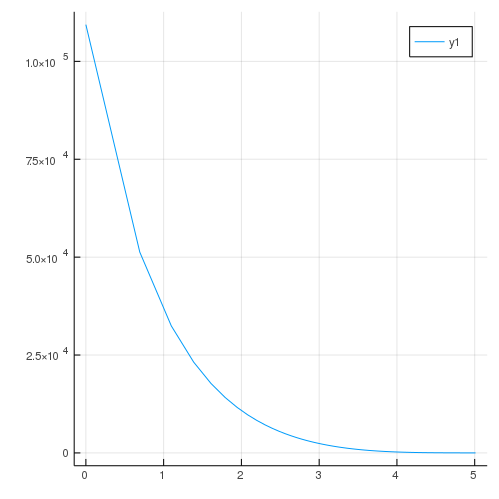

In [85]:
ln_energy_p = log.(energy_p)
plot(ln_energy_p, arr_spectrum_real_p)

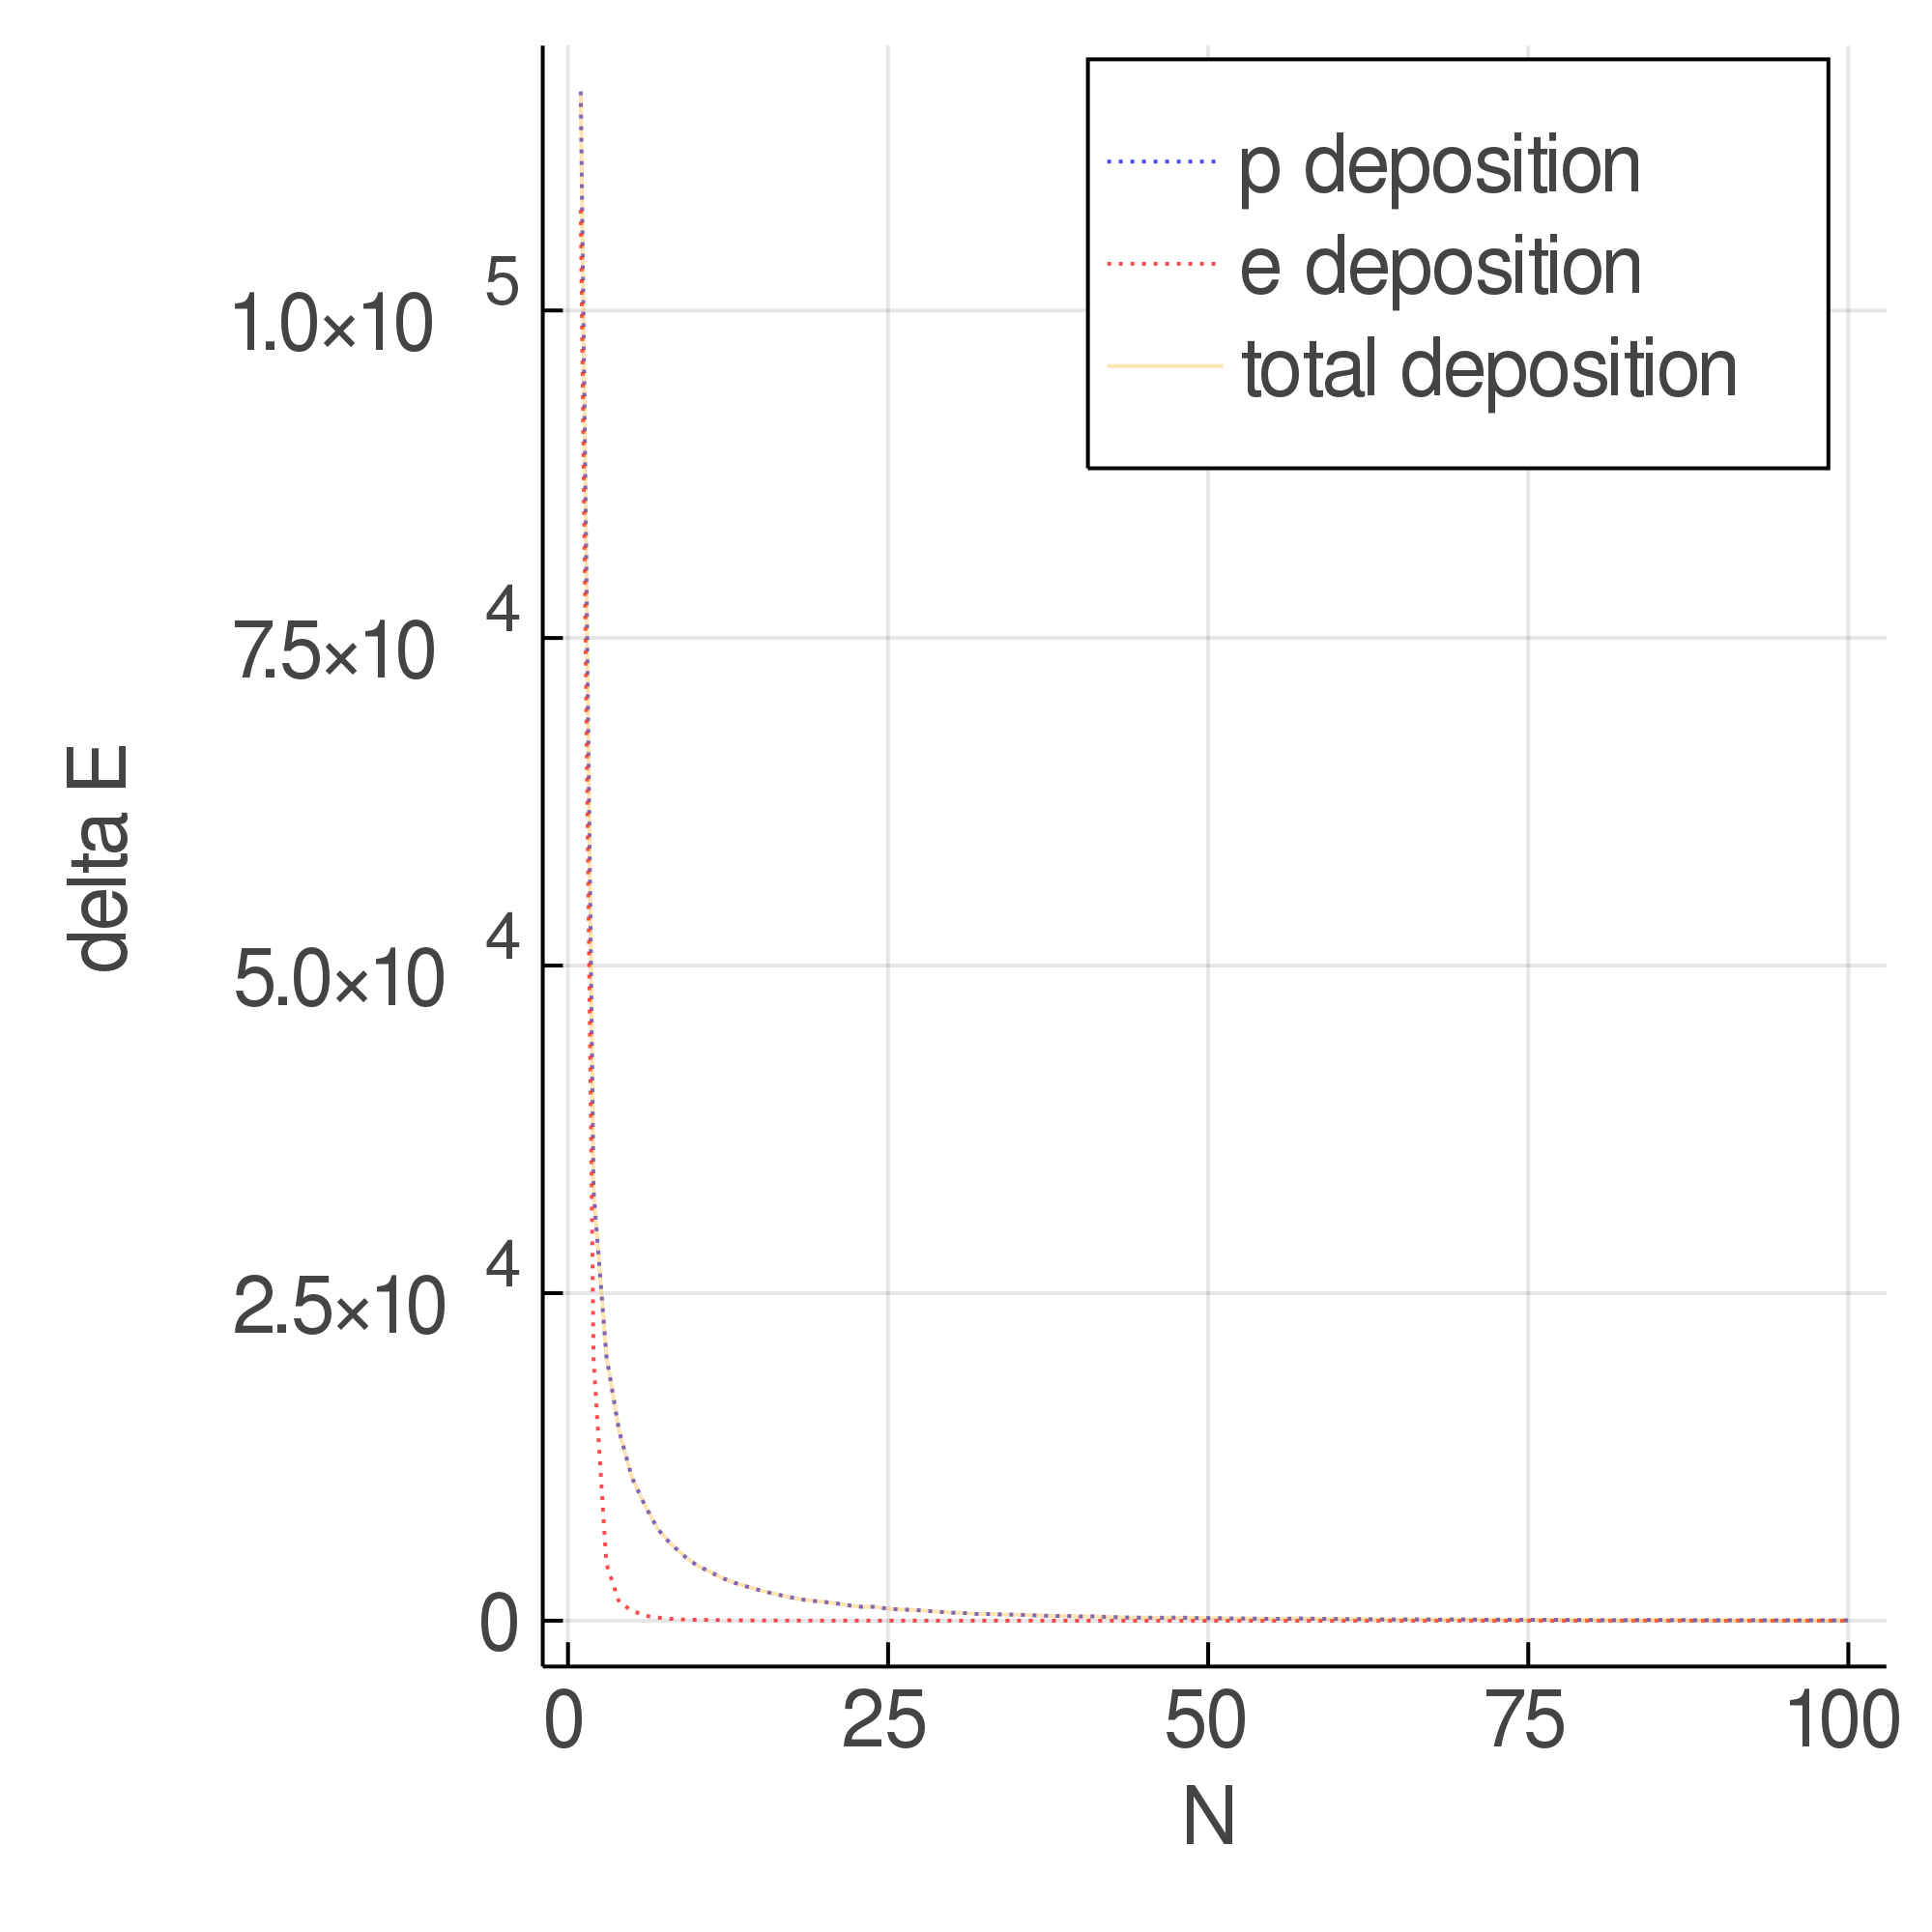

In [50]:
# plot(f_y_p)
# plot!(f_y)

# f_y_corrected = [max(f, 1) for f in f_y]
# println(f_y_corrected)

# plot(log.(10, f_y_p), label="p response", dpi=400,
#     xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :red)
# plot!(log.(10, f_y_corrected), label="e response", dpi=400,
#     xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
#     xlabel="N", ylabel="log delta(E)")
# savefig("p_e_log_response.png")

plot(f_y_p, label="p deposition", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue, linestyle=:dot,
    alpha=0.7)
plot!(f_y, label="e deposition", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :red,
    xlabel="N", ylabel="delta E", linestyle=:dot, alpha=0.7)
plot!(f_y_p, label="total deposition", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :orange, alpha=0.3)
# savefig("deposition.png")

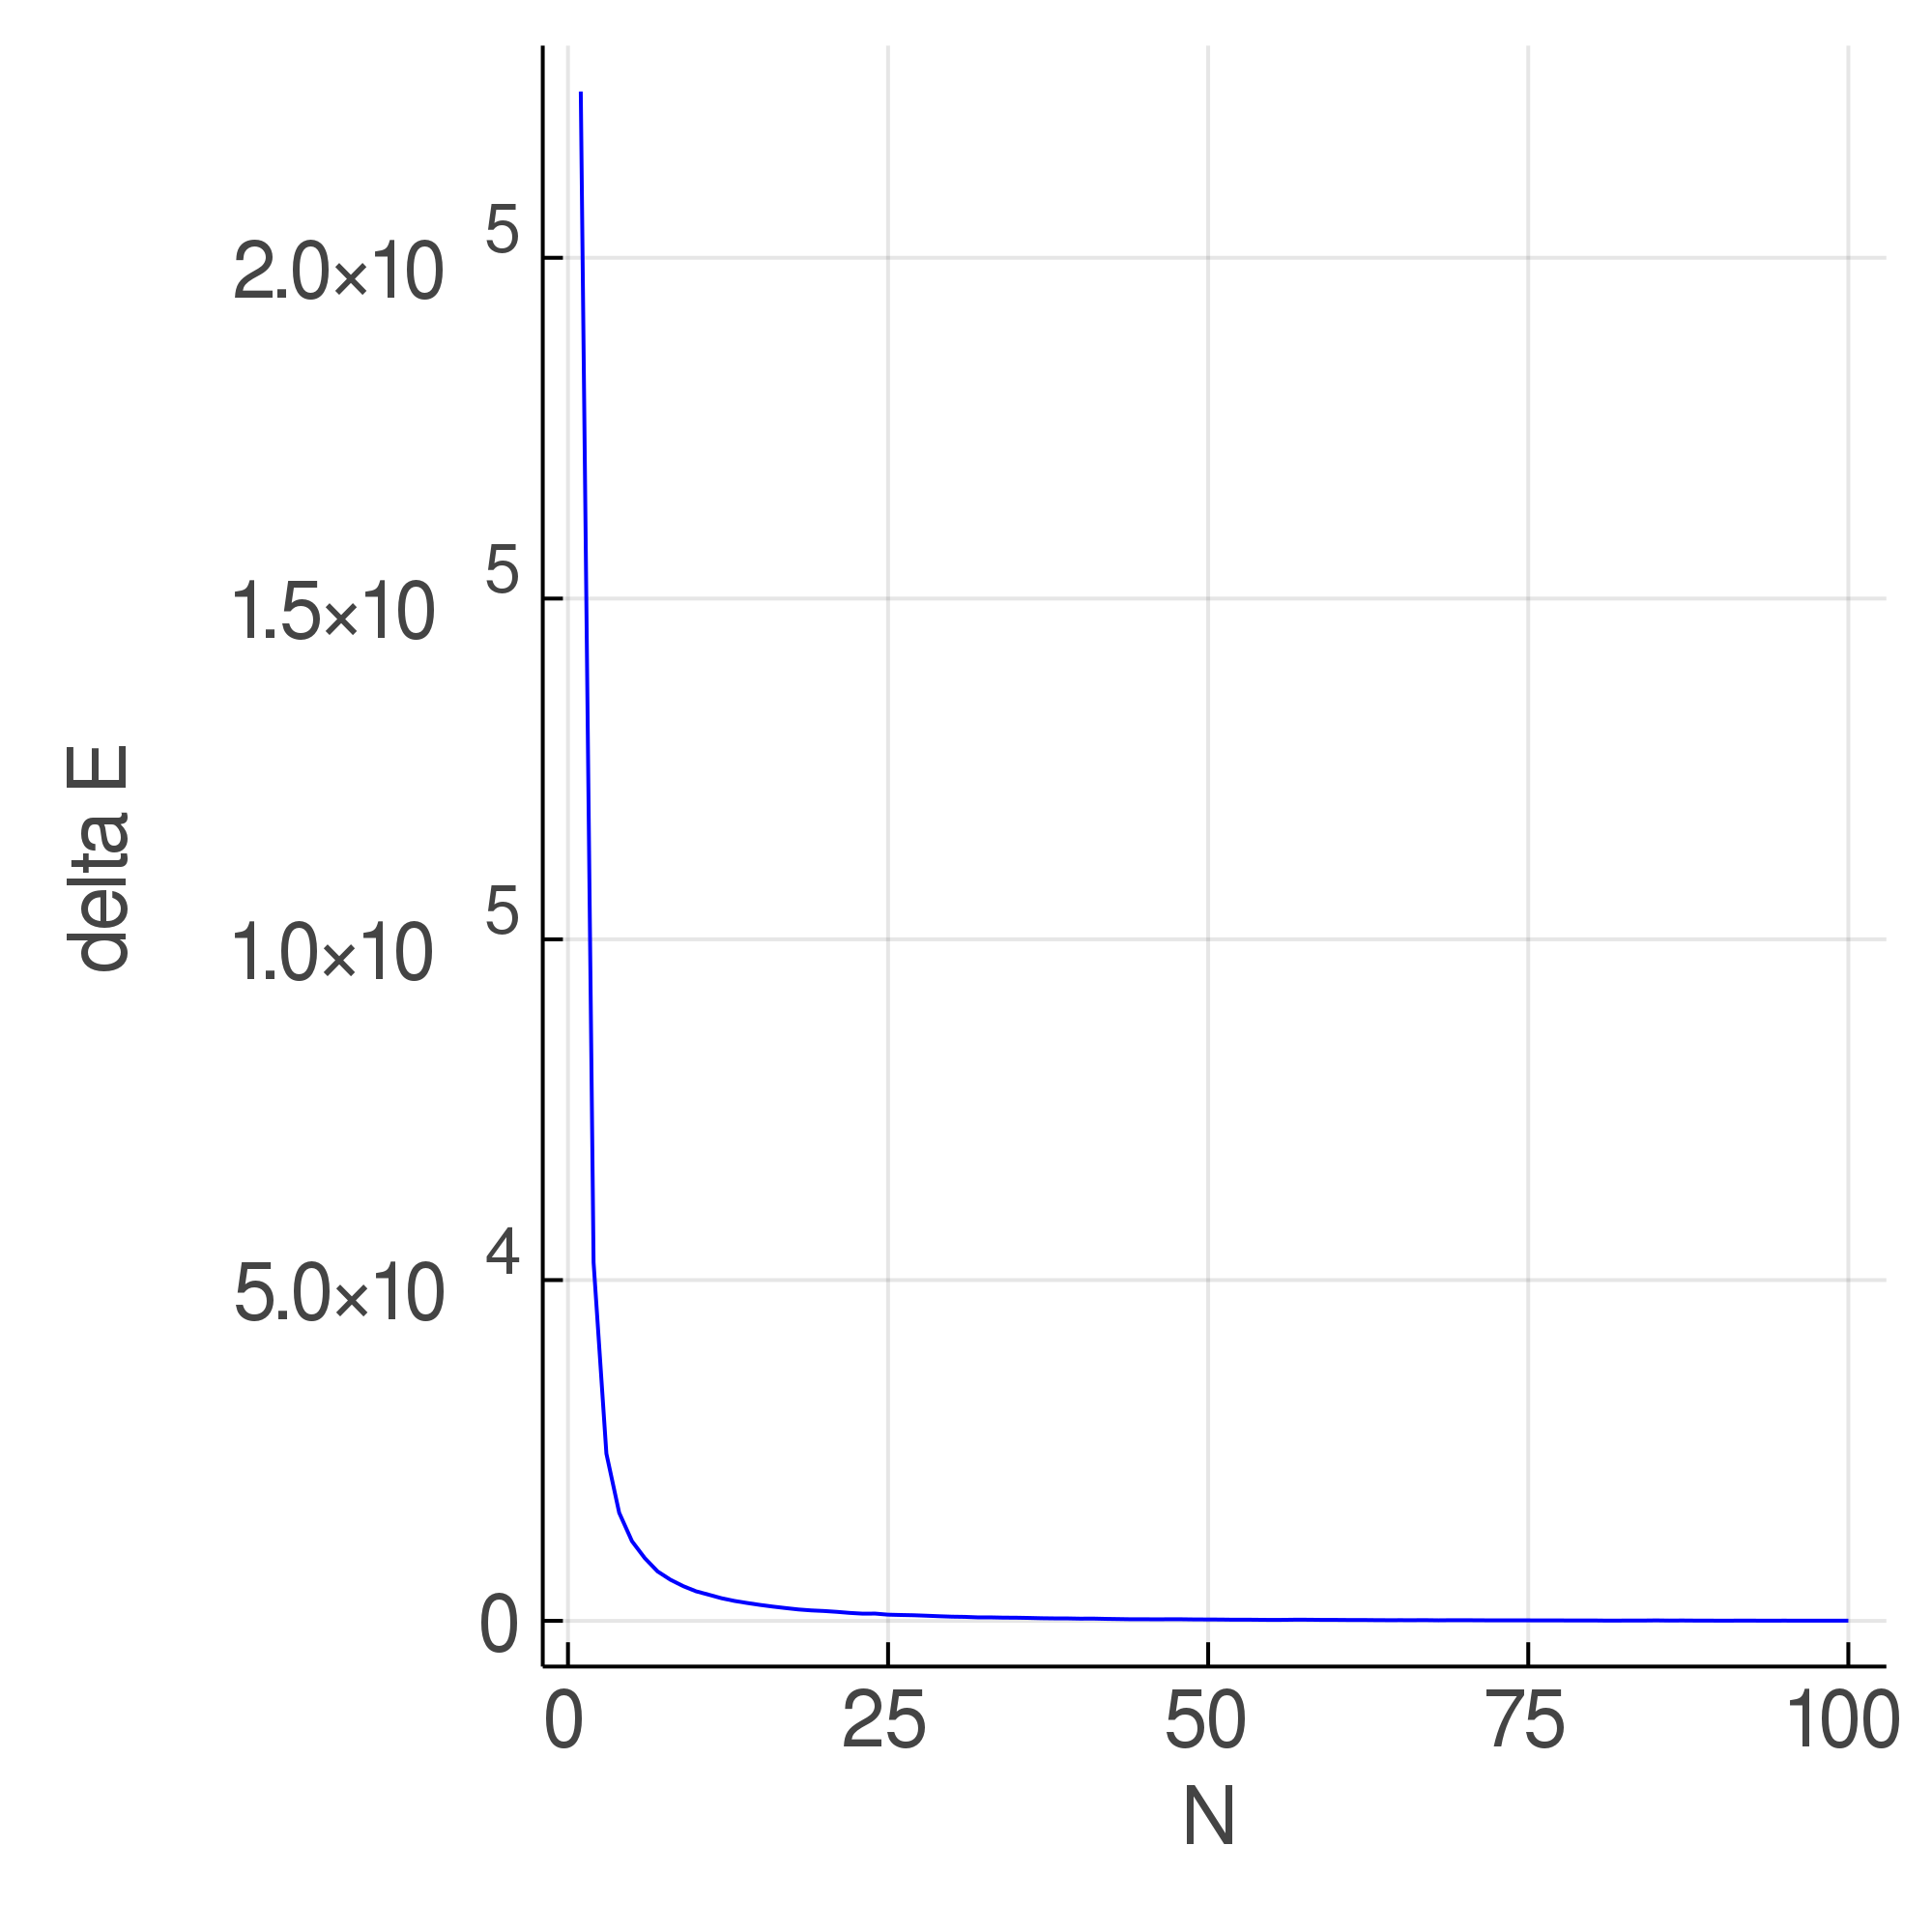

In [51]:
plot(f_y + f_y_p, dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
    xlabel="N", ylabel="delta E", label="")
# savefig("p_e_sum_response.png")

In [137]:
@memoize function K_cont(E, y)
    if E in energy
        return K(E, y)
    end
    E_max = energy[findfirst(x -> x>=E, energy)]
    E_min = energy[findlast(x -> x<=E, energy)]
    return (K(E_min, y) * (E_max - E) + K(E_max, y) * (E - E_min)) / (E_max - E_min)
end

@memoize function K_cont_ln(E, y)
    return K_cont(exp(E), y) * exp(E)
end

K_cont_ln (generic function with 1 method)

In [138]:
@memoize function K_cont_p(E, y)
    if E in energy_p
        return K(E, y)
    end
    E_max = energy_p[findfirst(x -> x>=E, energy_p)]
    E_min = energy_p[findlast(x -> x<=E, energy_p)]
    return (K_p(E_min, y) * (E_max - E) + K_p(E_max, y) * (E - E_min)) / (E_max - E_min)
end

@memoize function K_cont_p_ln(E, y)
    return K_cont_p(exp(E), y) * exp(E)
end

K_cont_p_ln (generic function with 1 method)

In [139]:
sig = 0.01*f_y + [max(sqrt(i), 1) for i in f_y]
f = f_y + f_y_p;
# plot(f, ribbon=sig, fillalpha=0.3, xlabel="y", ylabel="f", label="", dpi=400,
#     xtickfontsize=14, ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue)
# savefig("f_y_cont.png")

In [140]:
E_min = 1
E_max = 150
a = log(E_min)
b = log(E_max)
basis = CubicSplineBasis(a, b, 60, (nothing, "dirichlet"));
Omega = omega(basis);


┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:107
┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:122
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:140


In [141]:
model = GaussErrorUnfolder(basis, [Omega], "User", alphas=[0.1440379000137214]);

┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:56
┌ Info: GaussErrorUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:161


In [142]:
@time result = solve(model, K_cont_p_ln, f, sig, collect(range(1, stop=100)));
# @time result_another = solve(model, K_another, f, sig, collect(range(1, stop=100)));

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:194
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44


 46.429517 seconds (1.08 G allocations: 27.947 GiB, 36.34% gc time)


┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:86
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:105
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:202


In [143]:
# plot(result["coeff"] - result_another["coeff"])

┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solution_utils/vector.jl:64


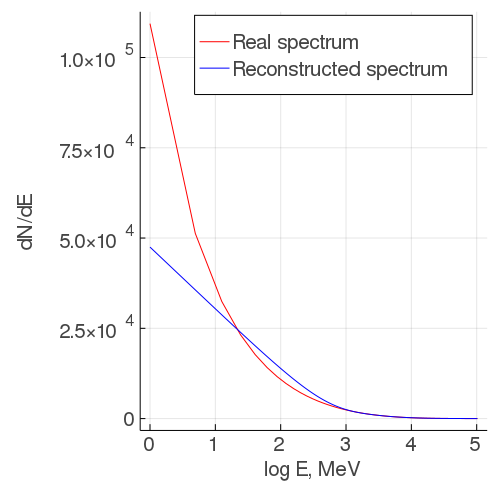

In [146]:
x = collect(range(a, b, length=500))
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(ln_energy_p, arr_spectrum_real_p, label="Real spectrum", color=:red)
plot!(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3,
    label="Reconstructed spectrum", xlabel="log E, MeV", ylabel="dN/dE", color = :blue,
    xtickfontsize=14,ytickfontsize=14, legendfontsize=14, guidefont=font(14))#, dpi=400)
# savefig("reconstructed_cont_p_e.png")

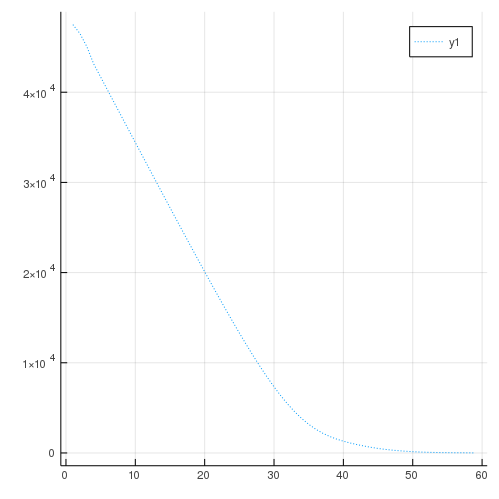

In [147]:
plot(result["coeff"], line=:dot)

0.964632672193447

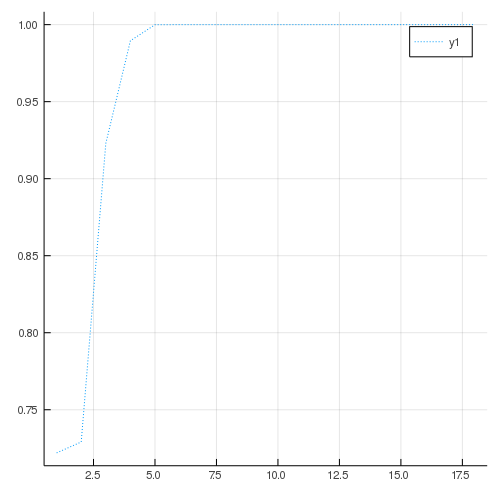

In [114]:
arr_rec = phivec.phi_function.(energy_p)
for_plot = [abs(arr_rec[i]-arr_spectrum_real_p[i])/arr_spectrum_real_p[i] for i in range(1, stop=length(arr_rec[1:18]))]
print(mean(for_plot))
plot(for_plot, linestyle=:dot)

In [21]:
# x = collect(range(1, 150, length=500))
# phivec_another = PhiVec(result_another, basis)

# phi_reconstructed_another = phivec_another.phi_function.(x)
# phi_reconstructed_errors_another = phivec_another.error_function.(x)

# plot(collect(range(1, stop=150)), arr_spectrum_real, label="Real spectrum", color=:red)
# plot!(x, phi_reconstructed_another, ribbon=phi_reconstructed_errors_another, fillalpha=0.3,
#     label="Reconstructed spectrum", xlabel="E, MeV", ylabel="N", color = :blue,)
# #     xtickfontsize=12,ytickfontsize=12, legendfontsize=12, guidefont=font(12),  dpi=200)
# # savefig("reconstructed_cont.png")

In [22]:
# arr_rec_another = phivec_another.phi_function.(energy)
# for_plot_another = [abs(arr_rec_another[i]-arr_spectrum_real[i])/arr_spectrum_real[i] for i in range(1, stop=length(arr_rec))]
# print(mean(for_plot_another))
# plot(for_plot_another, linestyle=:dot)